# Novel enhanced quantum representation of digital images - [NEQR](https://www.overleaf.com/project/61911febed45e965f929d7c0#cite.zhang2013neqr)

$| I \rangle = \frac{1}{2^n}\sum_{Y=0}^{2^n-1}\sum_{X=0}^{2^n-1}\bigotimes_{i=0}^{q-1} | C_{YX}^{i}\rangle | YX \rangle$, where

$| C_{YX}^{i}\rangle$ and $| YX \rangle$ are pixel intensity and coordinate expansion respectively

Step 0: dependencies import

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit.extensions import XGate
from ibm_washington_config import coupling_map, basis_gates

Step 1: image generation

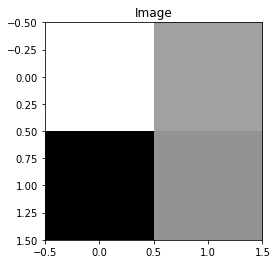

In [2]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

Step 2: NEQR image encoding

In [3]:
indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

Metrics

| Image size  | Depth measure | # of utilized qubits
| ------------- | ------------- | -------------------|
| 2  | 22  | 10 |
| 4  | 88  | 12 |
| 8  | 375  |14 |
| 16  | 1513  | 16 |
| 32  | 6075  | 18 |
| 64  | 24410  | 20 |
| 128  | 97923  | 22 |
| 256  | 392281  | 24 |

In [4]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 25, # of qubits is 10


In [5]:
wash_qc = transpile(circuits=qc_image, coupling_map=coupling_map, basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))
# wash_qc.draw()

depth is 528


Circuit visualization

In [7]:
# qc_image.draw()

Step 3: circuit execution

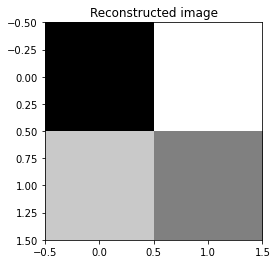

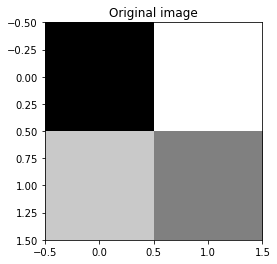

[ 50. 191. 161. 121.] 
 [ 50 191 161 121]


In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))
plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())